In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/data science/marketprophecy-main/NSE Data')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,ridge_regression
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import LSTM,Dense

In [4]:
data= pd.read_csv('NSE Training Data - 1st Jan 2016 to 1st Jan 2022.csv')
test=pd.read_csv('NSE Out of Time Testing Data - 1st Jan 2022 to 4th Feb 2022.csv')

In [5]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,7924.549805,7937.549805,7781.100098,7791.299805,7791.299805,134700.0
1,2016-01-05,7828.399902,7831.200195,7763.250000,7784.649902,7784.649902,145200.0
2,2016-01-06,7788.049805,7800.950195,7721.200195,7741.000000,7741.000000,147100.0
3,2016-01-07,7673.350098,7674.950195,7556.600098,7568.299805,7568.299805,188900.0
4,2016-01-08,7611.649902,7634.100098,7581.049805,7601.350098,7601.350098,157400.0


In [6]:
print(data.shape)
print(test.shape)

(1481, 7)
(23, 7)


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1481 entries, 0 to 1480
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1481 non-null   object 
 1   Open       1475 non-null   float64
 2   High       1475 non-null   float64
 3   Low        1475 non-null   float64
 4   Close      1475 non-null   float64
 5   Adj Close  1475 non-null   float64
 6   Volume     1475 non-null   float64
dtypes: float64(6), object(1)
memory usage: 81.1+ KB


In [8]:
data.isnull().sum()

Date         0
Open         6
High         6
Low          6
Close        6
Adj Close    6
Volume       6
dtype: int64

In [9]:
data[data.isna().any(axis=1)]

,Date,Open,High,Low,Close,Adj Close,Volume
151,2016-08-12,NaN,NaN,NaN,NaN,NaN,NaN
493,2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN
739,2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN
937,2019-10-27,NaN,NaN,NaN,NaN,NaN,NaN
1201,2020-11-14,NaN,NaN,NaN,NaN,NaN,NaN
1233,2021-01-01,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
data["Date"]=pd.to_datetime(data.Date,format="%Y-%m-%d")
data.index=data['Date']

In [11]:
data.dropna(inplace=True)
print(data.shape)
print(data.isnull().sum())

(1475, 7)
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


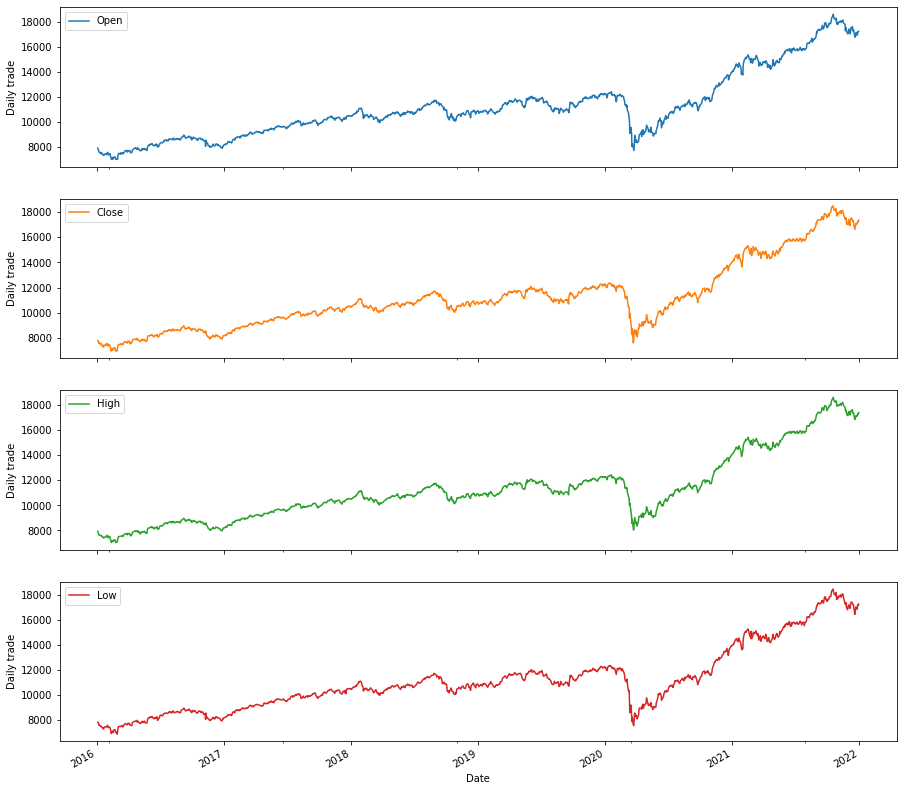

In [73]:
cols_plot = ['Open', 'Close', 'High','Low']
axes = data[cols_plot].plot(figsize=(15, 15), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

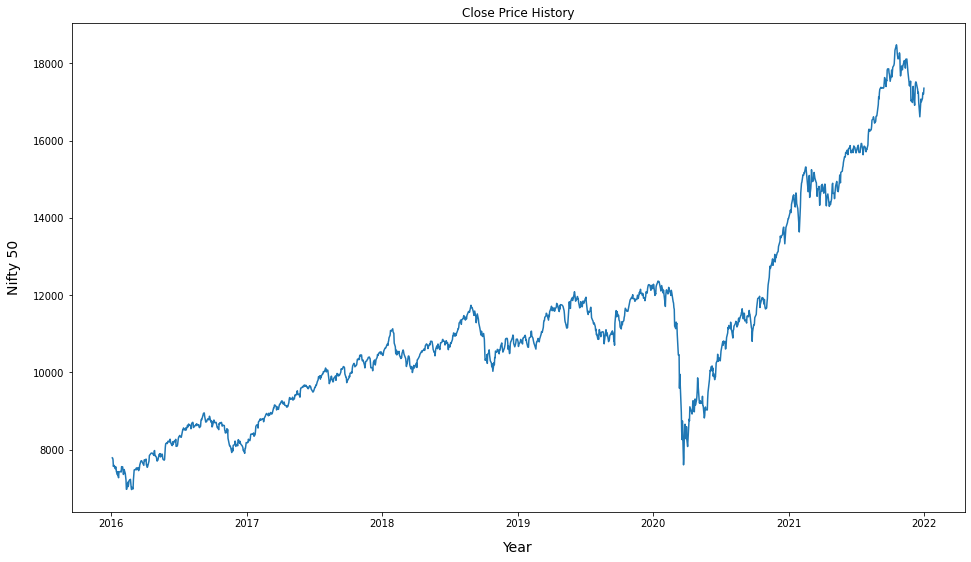

In [12]:
plt.figure(figsize=(16,9))
plt.plot(data['Close'])
plt.title('Close Price History')
plt.xlabel('Year',fontsize=14,labelpad=12)
plt.ylabel('Nifty 50',fontsize=14,labelpad=12)
plt.show()

In [46]:
# Create a new dataframe with only the 'Close column 
new_data = data.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = new_data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .90 ))

training_data_len



1328

In [47]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.07132518],
       [0.07074726],
       [0.06695374],
       ...,
       [0.89019627],
       [0.88935758],
       [0.90240257]])

In [48]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

In [69]:
model= Sequential()
model.add(LSTM(60,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(60,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [70]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [71]:
model.fit(x_train,y_train,batch_size=5,epochs=2)

Epoch 1/2
254/254 [==============================] - 16s 48ms/step - loss: 0.0021
Epoch 2/2
254/254 [==============================] - 13s 50ms/step - loss: 7.6386e-04


In [72]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

514.1276354878338

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


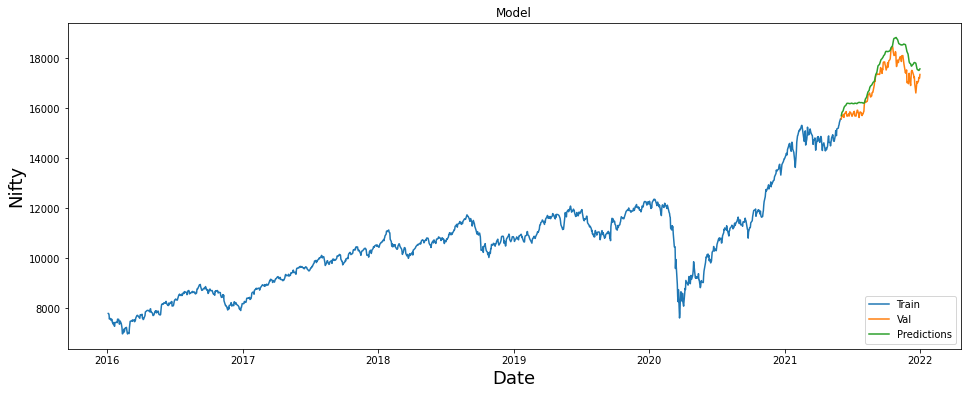

In [74]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Nifty', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

